In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [46]:
# HELPER FUNCTIONS

def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def read_csv(filename):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

In [47]:
X_train, Y_train = read_csv('../input/emojify/train_emoji.csv')
X_test, Y_test = read_csv('../input/emojify/test_emoji.csv')

In [48]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)
# print(Y_oh_test)

In [49]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('../input/glove-global-vectors-for-word-representation/glove.6B.50d.txt')

In [50]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    """
    
    m = X.shape[0]  # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):  # loop over training examples
        
        # Convert the ith sentence in lower case and split into a list of words
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
            j = j + 1
    
    return X_indices

In [51]:
X1 = np.array(["nice", "I am happy", "The food is terrible"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['nice' 'I am happy' 'The food is terrible']
X1_indices = [[260760.      0.      0.      0.      0.]
 [185457.  52943. 173081.      0.      0.]
 [357266. 151204. 192973. 356326.      0.]]


In [52]:
class NN(nn.Module):
    def __init__(self, embedding, embedding_dim, hidden_dim, vocab_size, output_dim, batch_size):
        super(NN, self).__init__()

        self.batch_size = batch_size

        self.hidden_dim = hidden_dim

        self.word_embeddings = embedding

      # The LSTM takes word embeddings as inputs, and outputs hidden states
      # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, 
                          hidden_dim, 
                          num_layers=2,
                          dropout = 0.5,
                          batch_first = True)

      # The linear layer that maps from hidden state space to output space
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, sentence):
      
      #sentence = sentence.type(torch.LongTensor)
      #print ('Shape of sentence is:', sentence.shape)

        sentence = sentence.to(device)

        embeds = self.word_embeddings(sentence)
      #print ('Embedding layer output shape', embeds.shape)

      # initializing the hidden state to 0
      #hidden=None
    
        h0 = torch.zeros(2, sentence.size(0), hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(2, sentence.size(0), hidden_dim).requires_grad_().to(device)
      
        lstm_out, h = self.lstm(embeds, (h0, c0))
      # get info from last timestep only
        lstm_out = lstm_out[:, -1, :]
      #print ('LSTM layer output shape', lstm_out.shape)
      #print ('LSTM layer output ', lstm_out)

      # Dropout
        lstm_out = F.dropout(lstm_out, 0.5)

        fc_out = self.fc(lstm_out)
      #print ('FC layer output shape', fc_out.shape)
      #print ('FC layer output ', fc_out)
      
        out = fc_out
        out = F.softmax(out, dim=1)
      #print ('Output layer output shape', out.shape)
      #print ('Output layer output ', out)
        return out

In [53]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=True):
    num_embeddings = len(word_to_index) + 1                   
    embedding_dim = word_to_vec_map["cucumber"].shape[0]  #  dimensionality of GloVe word vectors (= 50)

    # Initialize the embedding matrix as a numpy array of zeros of shape (num_embeddings, embedding_dim)
    weights_matrix = np.zeros((num_embeddings, embedding_dim))

    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        weights_matrix[index, :] = word_to_vec_map[word]

    embed = nn.Embedding.from_pretrained(torch.from_numpy(weights_matrix).type(torch.FloatTensor), freeze=non_trainable)

    return embed, num_embeddings, embedding_dim

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model, trainloader, criterion, optimizer, epochs=10):
    
    model.to(device)
    running_loss = 0
    
    train_losses, test_losses, accuracies = [], [], []
    for e in range(epochs):

        running_loss = 0
        
        model.train()
        
        for sentences, labels in trainloader:

            sentences, labels = sentences.to(device), labels.to(device)

            # 1) erase previous gradients (if they exist)
            optimizer.zero_grad()

            # 2) make a prediction
            pred = model.forward(sentences)

            # 3) calculate how much we missed
            loss = criterion(pred, labels)

            # 4) figure out which weights caused us to miss
            loss.backward()

            # 5) change those weights
            optimizer.step()

            # 6) log our progress
            running_loss += loss.item()
        
        
        else:

            model.eval()

            test_loss = 0
            accuracy = 0
          
          # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                for sentences, labels in test_loader:
                    sentences, labels = sentences.to(device), labels.to(device)
                    log_ps = model(sentences)
                    test_loss += criterion(log_ps, labels)
                  
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
                  
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))
            accuracies.append(accuracy / len(test_loader) * 100)

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
        
    # Plot
    plt.figure(figsize=(20, 5))
    plt.plot(train_losses, c='b', label='Training loss')
    plt.plot(test_losses, c='r', label='Testing loss')
    plt.xticks(np.arange(0, epochs))
    plt.title('Losses')
    plt.legend(loc='upper right')
    plt.show()
    plt.figure(figsize=(20, 5))
    plt.plot(accuracies)
    plt.xticks(np.arange(0, epochs))
    plt.title('Accuracy')
    plt.show()

Epoch: 1/50..  Training Loss: 1.605..  Test Loss: 1.592..  Test Accuracy: 0.344
Epoch: 2/50..  Training Loss: 1.585..  Test Loss: 1.572..  Test Accuracy: 0.219
Epoch: 3/50..  Training Loss: 1.572..  Test Loss: 1.549..  Test Accuracy: 0.318
Epoch: 4/50..  Training Loss: 1.557..  Test Loss: 1.539..  Test Accuracy: 0.339
Epoch: 5/50..  Training Loss: 1.534..  Test Loss: 1.525..  Test Accuracy: 0.380
Epoch: 6/50..  Training Loss: 1.486..  Test Loss: 1.504..  Test Accuracy: 0.411
Epoch: 7/50..  Training Loss: 1.474..  Test Loss: 1.482..  Test Accuracy: 0.464
Epoch: 8/50..  Training Loss: 1.442..  Test Loss: 1.472..  Test Accuracy: 0.396
Epoch: 9/50..  Training Loss: 1.381..  Test Loss: 1.437..  Test Accuracy: 0.453
Epoch: 10/50..  Training Loss: 1.382..  Test Loss: 1.432..  Test Accuracy: 0.464
Epoch: 11/50..  Training Loss: 1.332..  Test Loss: 1.412..  Test Accuracy: 0.490
Epoch: 12/50..  Training Loss: 1.348..  Test Loss: 1.438..  Test Accuracy: 0.443
Epoch: 13/50..  Training Loss: 1.352.

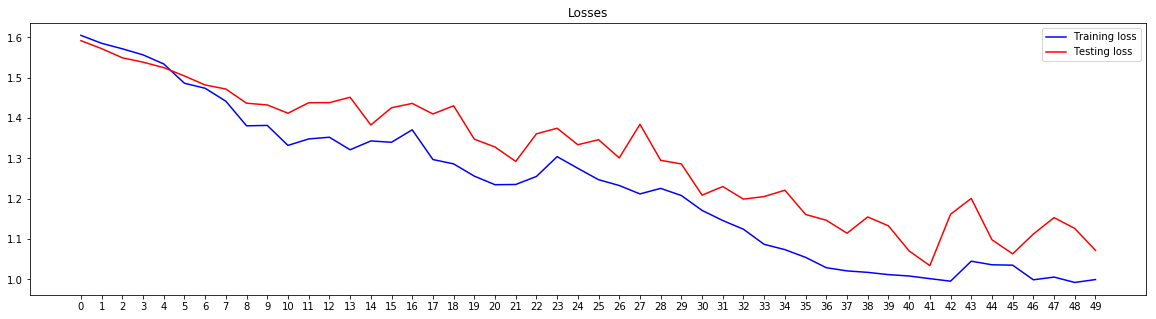

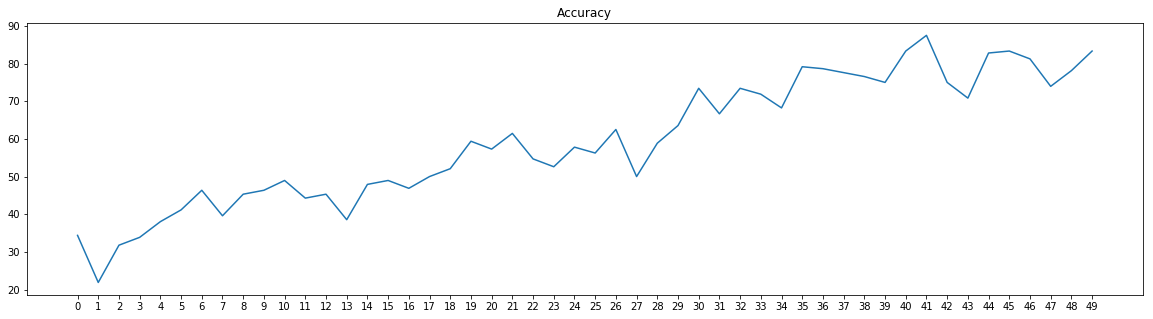

In [71]:
maxLen = len(max(X_train, key=len).split())
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)
# Y_train_oh = Y_train

X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
# Y_test_oh = Y_test

embedding, vocab_size, embedding_dim = pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=True)

hidden_dim=128
output_size=5
batch_size = 32

#print ('Embedding layer is ', embedding)
#print ('Embedding layer weights ', embedding.weight.shape)

model = NN(embedding, embedding_dim, hidden_dim, vocab_size, output_size, batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
epochs = 50
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_indices).type(torch.LongTensor), torch.tensor(Y_train).type(torch.LongTensor))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test_indices).type(torch.LongTensor), torch.tensor(Y_test).type(torch.LongTensor))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train(model, train_loader, criterion, optimizer, epochs)

In [72]:
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for sentences, labels in test_loader:
        sentences, labels = sentences.to(device), labels.to(device)
        ps = model(sentences)
        test_loss += criterion(ps, labels).item()

        # Accuracy
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
model.train()
print("Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
      "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
running_loss = 0

Test Loss: 1.079..  Test Accuracy: 0.812


In [73]:
def emotion_detector(input_text, print_sentence=True):
    labels_dict = {
        0 : "❤️ Loving",
        1 : "⚽️ Active",
        2 : "😄 Happy",
        3 : "😞 Annoyed",
        4 : "🍽 Foodie",
    }

    # Convert the input to the model
    x_test = np.array([input_text])
    X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
    sentences = torch.tensor(X_test_indices).type(torch.LongTensor)

    # Get the class label
    ps = model(sentences)
    top_p, top_class = ps.topk(1, dim=1)
    label = int(top_class[0][0])

    if print_sentence:
        print("\nInput Text: \t"+ input_text +'\nEmotion: \t'+  labels_dict[label])

    return label

In [74]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
print("------------------------------------")
emotion_detector("This is chocolate ice cream")
emotion_detector("Lets watch football")
emotion_detector("You are a nice guy")
emotion_detector("Today is really fun")
emotion_detector("you are so mean")
print("\n------------------------------------")

------------------------------------

Input Text: 	This is chocolate ice cream
Emotion: 	🍽 Foodie

Input Text: 	Lets watch football
Emotion: 	⚽️ Active

Input Text: 	You are a nice guy
Emotion: 	❤️ Loving

Input Text: 	Today is really fun
Emotion: 	😄 Happy

Input Text: 	you are so mean
Emotion: 	😞 Annoyed

------------------------------------
